In [1]:
# Importing dependencies

import pandas as pd                                              # For reading, analyzing, and preparing data
import numpy as np                                               # For operations on arrays
import seaborn as sns                                            # To visualize the results
import matplotlib.pyplot as plt                                  # Another visualizing library
from sklearn.preprocessing import MinMaxScaler, StandardScaler   # For feature scaling of the data
from sklearn.decomposition import PCA                            # A dimensionality reduction algorithm
from sklearn.neighbors import NearestNeighbors                   # To find the nearest neighbors for the DBSCAN parameter
from sklearn.cluster import DBSCAN                               # Unsupervised clustering algorithm
from sklearn.model_selection import train_test_split             # For partitioning the data into training and testing
from sklearn.svm import OneClassSVM                              # Unsupervised learning algorithm
from sklearn.metrics import confusion_matrix                     # Calculates count of Predicted vs Actual values
from sklearn.metrics import classification_report                # Calculates the performance metrics of a model
from sklearn.metrics import ConfusionMatrixDisplay               # To visualize the confusion matrix
from joblib import dump, load                                    # For saving and loading the models
import tensorflow as tf                                          # For deep neural network modeling
from keras import models, layers                                 # Adds models and layers to the neural network model
from keras.models import load_model                              # For loading the saved neural network model
from sklearn.ensemble import RandomForestClassifier              # Supervised ensemble learning algorithm
from sklearn.model_selection import cross_val_score, KFold       # Used to cross-validate the model by dividing the data into k-folds

### Data Extraction

In [2]:
# Reading the sensor and failure data

data = pd.read_csv("./metropt+3+dataset/MetroPT3(AirCompressor).csv")
failures = pd.read_csv("./metropt+3+dataset/MetroPT3-Failures.csv")
data.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
failures.head()

,Nr.,Start Time,End Time,Failure,Severity,Report
0,1,4/18/2020 0:00,4/18/2020 23:59,Air leak,High stress,NaN
1,2,5/29/2020 23:30,5/30/2020 6:00,Air Leak,High stress,Maintenance on 30Apr at 12:00
2,3,6/5/2020 10:00,6/7/2020 14:30,Air Leak,High stress,Maintenance on 8Jun at 16:00
3,4,7/15/2020 14:30,7/15/2020 19:00,Air Leak,High stress,Maintenance on 16Jul at 00:00


In [4]:
# Partially preparing data for analysis

# Changing datatype 
data['timestamp'] = pd.to_datetime(data['timestamp'])
failures['Start Time'] = pd.to_datetime(failures['Start Time'])
failures['End Time'] = pd.to_datetime(failures['End Time'])

# Merging failure data with sensor data
df = pd.merge_asof(data, failures, left_on='timestamp', right_on='Start Time')
df['failure'] = 0  # Initialize with 0
# Labelling records as failure by matching the start and end time
df.loc[(df['timestamp'] >= df['Start Time']) & (df['timestamp'] <= df['End Time']), 'failure'] = 1

# Dropping unwanted columns
df.drop(['Unnamed: 0','Nr.','Start Time', 'End Time', 'Severity', 'Report', 'Failure'], axis=1, inplace=True)
df.to_csv('metropt.csv', index=False)
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,failure
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0


### Data Analysis

In [5]:
# Provides count, mean, standard deviation and 5-point summary of each column of the dataset
df.describe()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,failure
count,1516948,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,2020-05-16 22:58:36.631517184,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01,1.974623e-02
min,2020-02-01 00:00:00,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2020-03-23 05:05:04.500000,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,2020-05-17 08:07:06,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2020-07-10 03:07:27.500000,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,2020-09-01 03:59:50,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,NaN,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01,1.391270e-01


In [6]:
# Checking for null values
df.isna().sum()

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
failure            0
dtype: int64

In [7]:
# Returns information of the dataset like datatype, non-null count, number of columns and rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   timestamp        1516948 non-null  datetime64[ns]
 1   TP2              1516948 non-null  float64       
 2   TP3              1516948 non-null  float64       
 3   H1               1516948 non-null  float64       
 4   DV_pressure      1516948 non-null  float64       
 5   Reservoirs       1516948 non-null  float64       
 6   Oil_temperature  1516948 non-null  float64       
 7   Motor_current    1516948 non-null  float64       
 8   COMP             1516948 non-null  float64       
 9   DV_eletric       1516948 non-null  float64       
 10  Towers           1516948 non-null  float64       
 11  MPG              1516948 non-null  float64       
 12  LPS              1516948 non-null  float64       
 13  Pressure_switch  1516948 non-null  float64       
 14  Oi

In [8]:
# Shape of the dataset (Instances, Features)
df.shape

(1516948, 17)

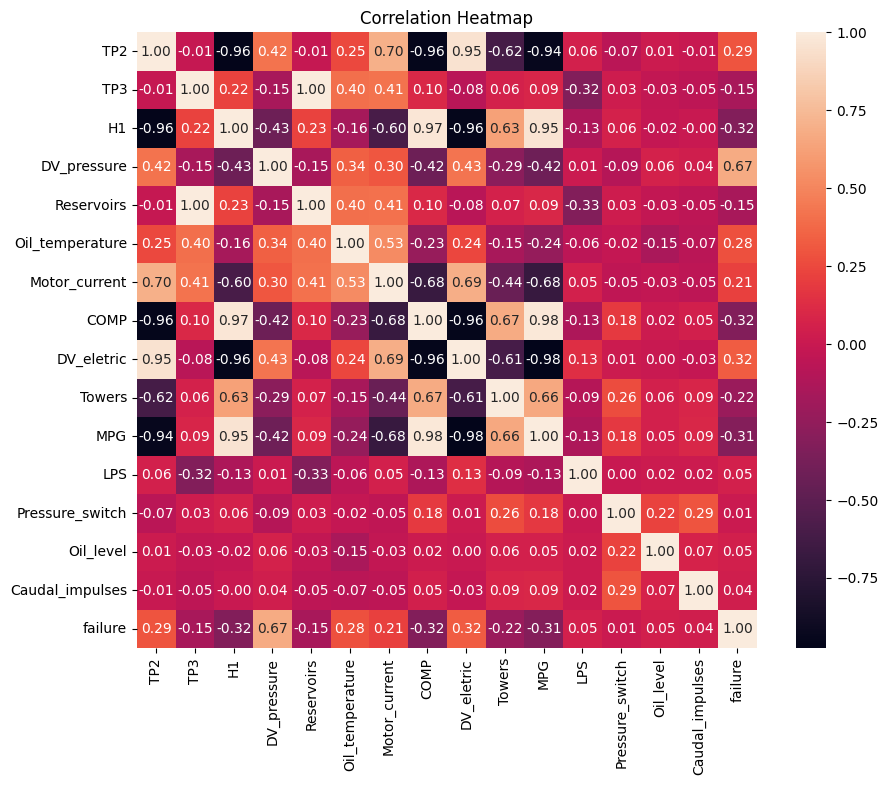

In [9]:
## Plotting a Correlation Matrix
correlation_matrix = df.corr(numeric_only = True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

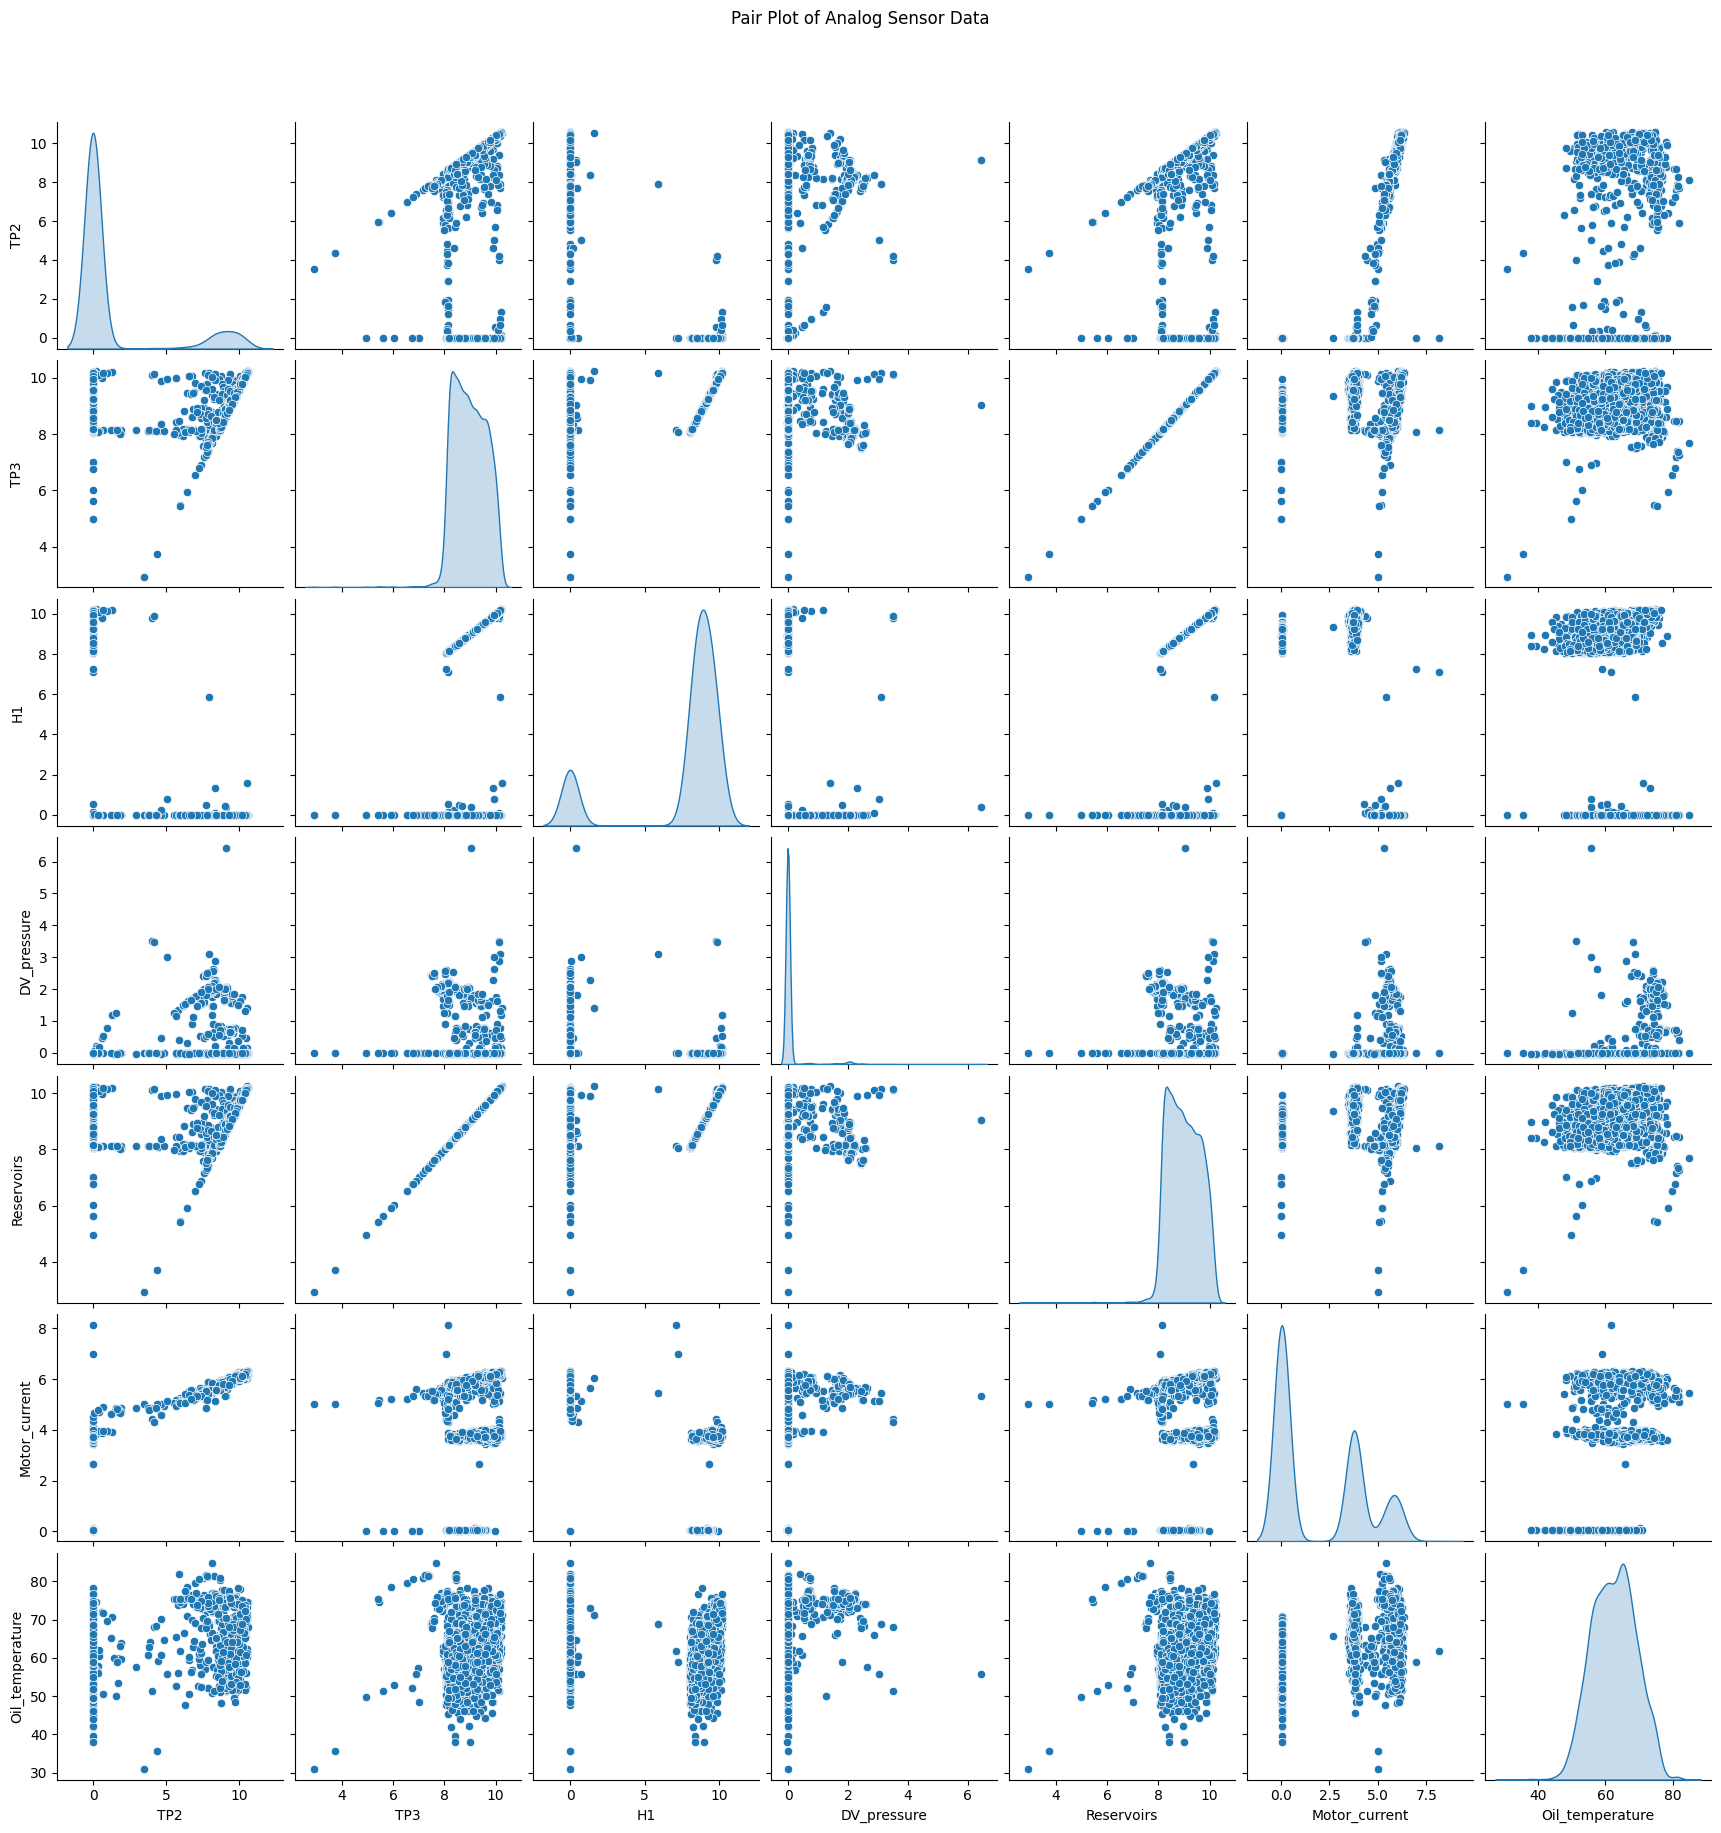

In [12]:
# Plotting a pairplot of continuous variables in the dataset
analog_sensors = df[['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']]
sns.pairplot(analog_sensors.sample(5000), diag_kind='kde')
plt.suptitle("Pair Plot of Analog Sensor Data", y=1.05)
plt.show()

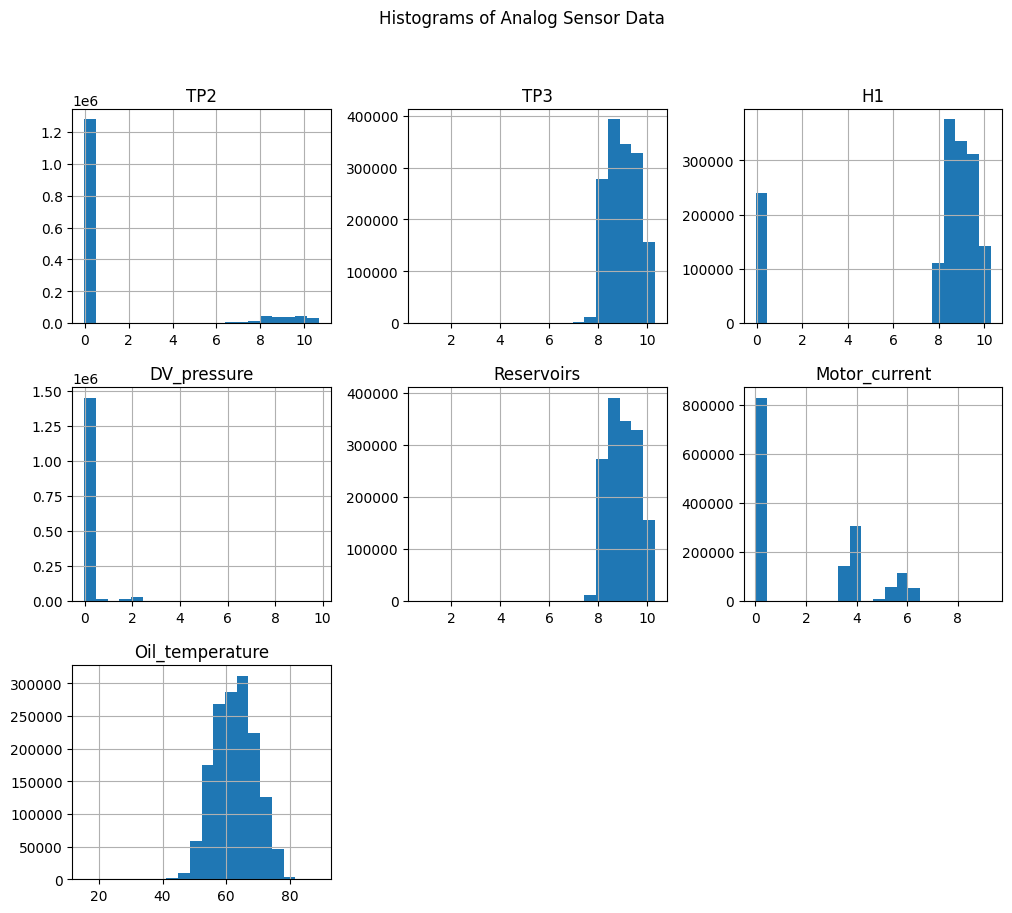

In [9]:
# Histogram of all the analog sensors
analog_sensors.hist(bins=20, figsize=(12, 10))
plt.suptitle("Histograms of Analog Sensor Data")
plt.show()

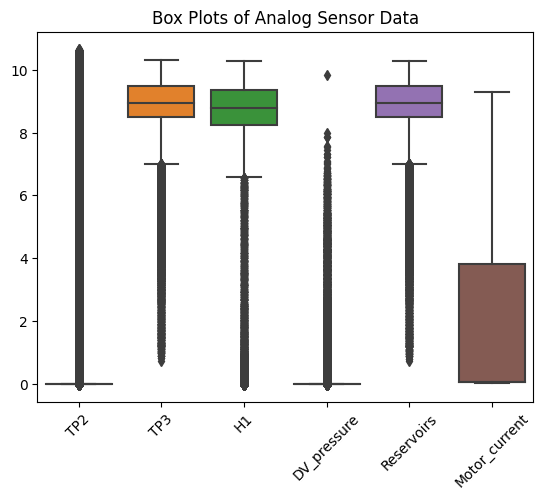

In [46]:
# Boxplot analysis of analog sensors
sns.boxplot(analog_sensors.loc[:, analog_sensors.columns != 'Oil_temperature'])
plt.title("Box Plots of Analog Sensor Data")
plt.xticks(rotation=45)
plt.show()

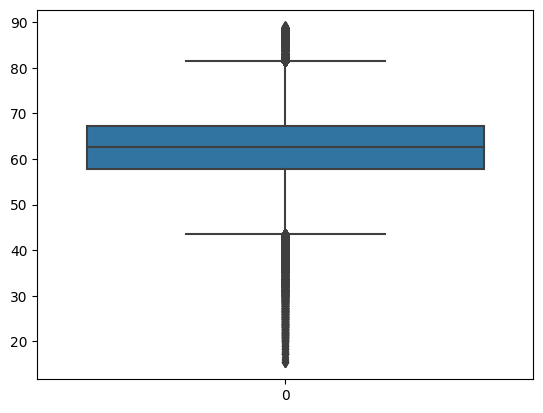

In [47]:
sns.boxplot(analog_sensors['Oil_temperature'])
plt.show()

In [50]:
# Digital sensor analysis (count of unique values)
digital_sensors = ['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

unique_value_counts = df[digital_sensors].apply(pd.Series.value_counts)
print("Unique Value Counts for Digital Sensors:")
print(unique_value_counts)

Unique Value Counts for Digital Sensors:
        COMP  DV_eletric   Towers      MPG      LPS  Pressure_switch  \
0.0   247328     1273310   121586   253840  1511760            12990   
1.0  1269620      243638  1395362  1263108     5188          1503958   

     Oil_level  Caudal_impulses  
0.0     145391            95406  
1.0    1371557          1421542  


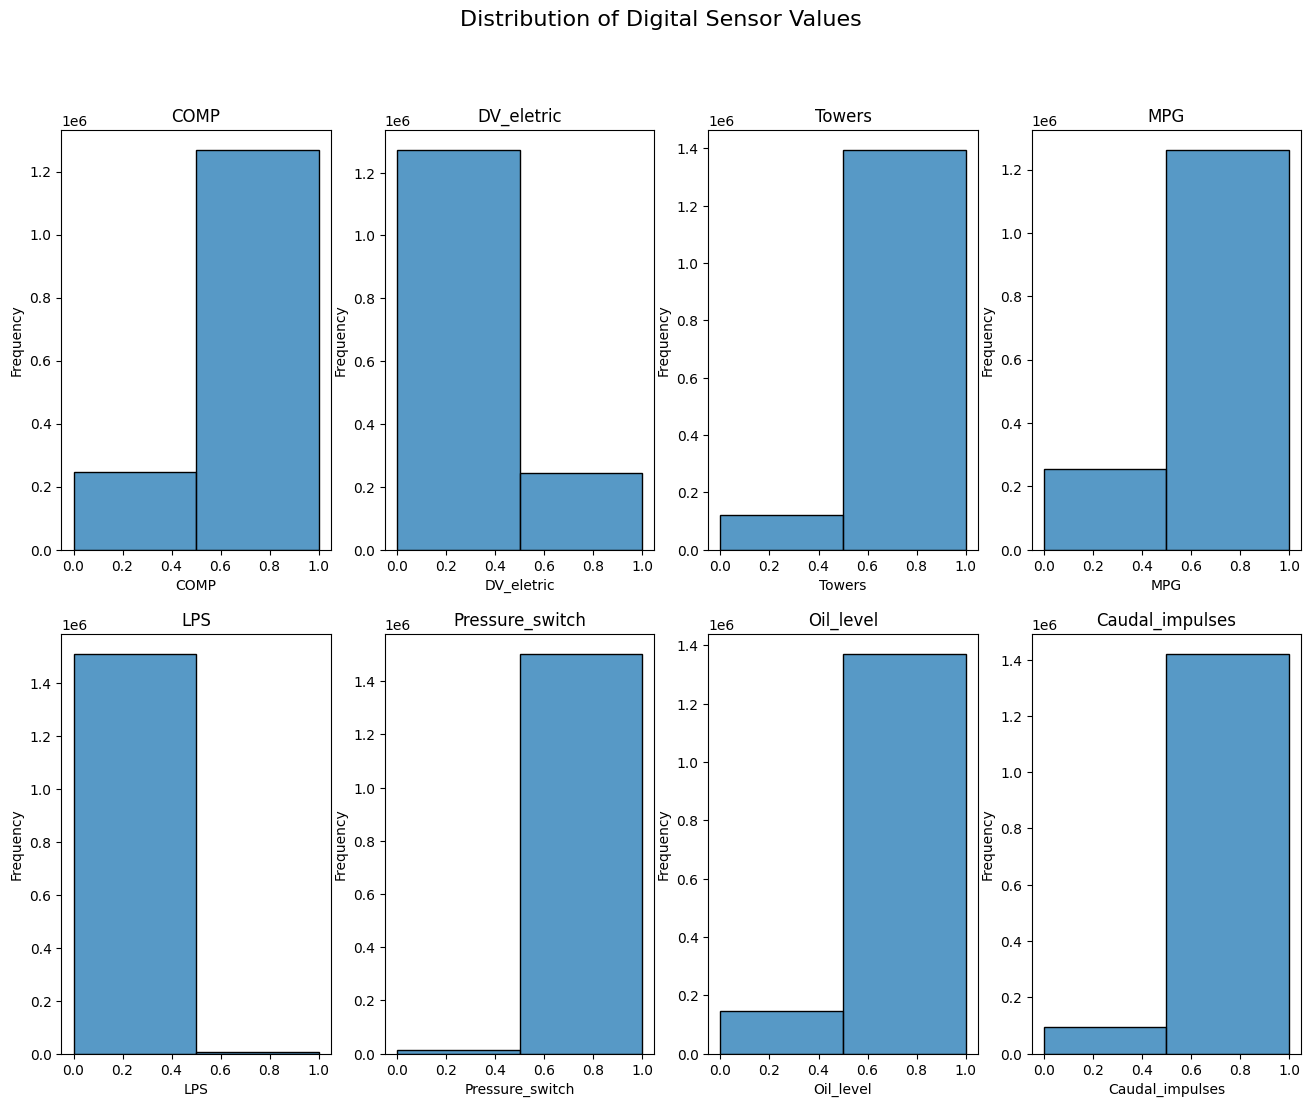

In [60]:
# Plotting the distribution of digital sensors
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))
fig.suptitle('Distribution of Digital Sensor Values', fontsize=16)

for i, sensor in enumerate(digital_sensors):
    row, col = divmod(i, 4)
    ax = axes[row, col]

    sns.histplot(data[sensor], bins=2, ax=ax)
    ax.set_title(sensor)
    ax.set_xlabel(sensor)
    ax.set_ylabel('Frequency')

plt.show()

In [165]:
# Retrieving the data one day prior and one day after the first failure
first_failure_df = df[(df['timestamp']>='2020-04-17') & (df['timestamp']<'2020-04-19')]
first_failure_df['failure'].value_counts()

failure
1    8657
0    6307
Name: count, dtype: int64

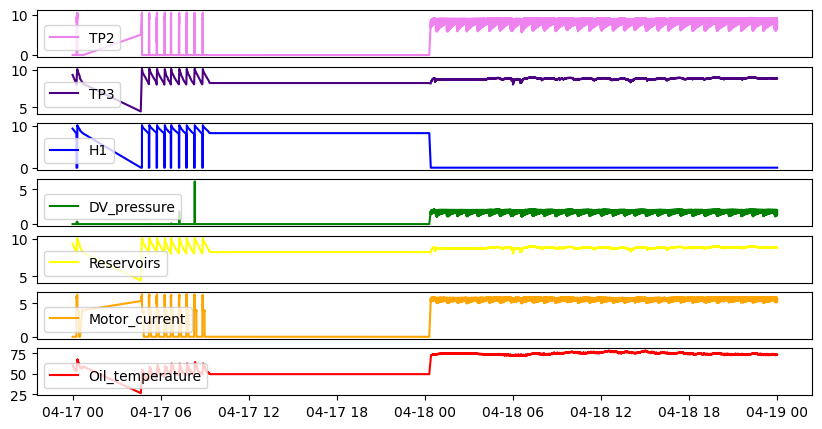

In [166]:
# Plotting the analog sensor data vs timestamp of the first failure

analog_sensors = first_failure_df[['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']]
colors = ['violet','indigo','blue','green','yellow','orange','red']

fig, axs = plt.subplots(7, 1, figsize=(10, 5))
for i in range(7):
    axs[i].plot(first_failure_df['timestamp'], analog_sensors.iloc[:,i], color=colors[i], label=analog_sensors.iloc[:,i].name)
    axs[i].get_xaxis().set_visible(False)
    axs[i].legend(loc='lower left')
axs[6].get_xaxis().set_visible(True)
plt.show()

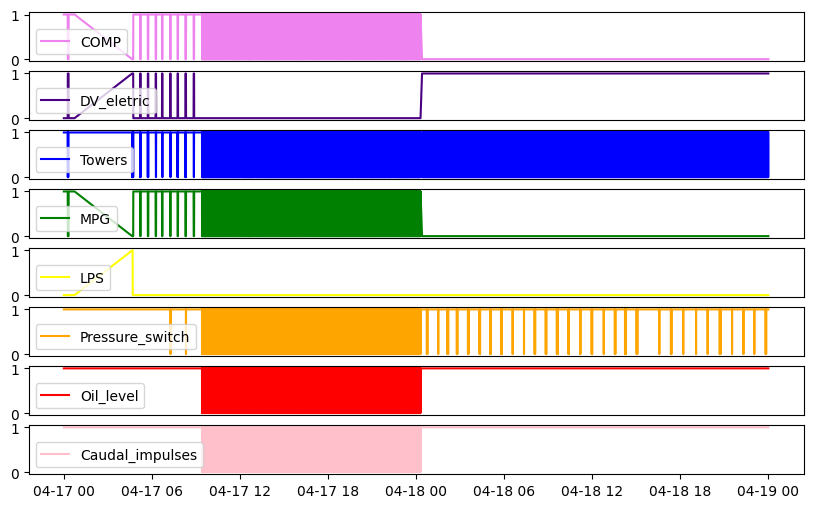

In [167]:
# Plotting the digital sensor data vs timestamp of the first failure

digital_sensors = first_failure_df[['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']]
colors = ['violet','indigo','blue','green','yellow','orange','red','pink']

fig, axs = plt.subplots(8, 1,figsize=(10,6))
for i in range(8):
    axs[i].plot(first_failure_df['timestamp'], digital_sensors.iloc[:,i], color=colors[i], label=digital_sensors.iloc[:,i].name)
    axs[i].get_xaxis().set_visible(False)
    axs[i].legend(loc='lower left')
axs[7].get_xaxis().set_visible(True)
plt.show()

In [21]:
# Getting the count of unique values of the target variable
df['failure'].value_counts()

failure
0    1486994
1      29954
Name: count, dtype: int64

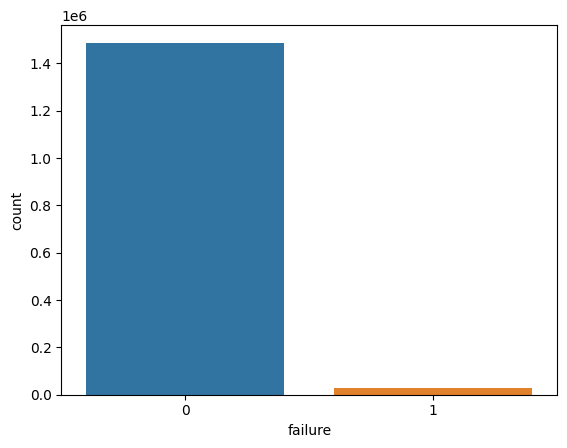

In [22]:
# Plotting the distribution of the target variable
sns.countplot(x=df["failure"])
plt.show()

### Data Preparation

In [5]:
# Extracting 4 new features from the timestamp variable

df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['week'] = df['timestamp'].dt.isocalendar().week
df['month'] = df['timestamp'].dt.month
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,failure,hour,day,week,month
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0,0,1,5,2
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0,0,1,5,2
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0,0,1,5,2
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0,0,1,5,2
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0,0,1,5,2


#### Standardization

In [6]:
# Scales the dataset to have a mean of 0 and a standard deviation of 1

scaler = StandardScaler()
temp_df = df.drop(['timestamp','failure'],axis=1)
sd_data = scaler.fit_transform(temp_df)
standardized_data = pd.DataFrame(sd_data, columns = temp_df.columns)
standardized_data.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,hour,day,week,month
0,-0.424441,0.584247,0.531575,-0.20909,0.583993,-1.387941,-0.873208,0.441367,-0.437427,0.295188,0.448291,-0.058581,0.092937,0.325583,0.259065,-1.765854,-1.680918,-1.730128,-1.496421
1,-0.425056,0.568600,0.529175,-0.20386,0.568326,-1.376431,-0.873208,0.441367,-0.437427,0.295188,0.448291,-0.058581,0.092937,0.325583,0.259065,-1.765854,-1.680918,-1.730128,-1.496421
2,-0.424441,0.552953,0.526175,-0.20386,0.552660,-1.387941,-0.872122,0.441367,-0.437427,0.295188,0.448291,-0.058581,0.092937,0.325583,0.259065,-1.765854,-1.680918,-1.730128,-1.496421
3,-0.424441,0.537306,0.523175,-0.20386,0.536993,-1.414797,-0.873208,0.441367,-0.437427,0.295188,0.448291,-0.058581,0.092937,0.325583,0.259065,-1.765854,-1.680918,-1.730128,-1.496421
4,-0.424441,0.521659,0.520175,-0.20386,0.521327,-1.407124,-0.873208,0.441367,-0.437427,0.295188,0.448291,-0.058581,0.092937,0.325583,0.259065,-1.765854,-1.680918,-1.730128,-1.496421


#### Normalization

In [7]:
# Scales the dataset to have to have a common scale in the range [0,1]

scaler = MinMaxScaler()
nm_data = scaler.fit_transform(temp_df)
normalized_data = pd.DataFrame(nm_data, columns = temp_df.columns)
normalized_data.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,hour,day,week,month
0,0.001868,0.901379,0.908175,0.000810,0.901752,0.518669,0.002156,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.001681,0.900334,0.907400,0.001013,0.900709,0.519688,0.002156,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.001868,0.899290,0.906432,0.001013,0.899666,0.518669,0.002426,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.001868,0.898245,0.905463,0.001013,0.898623,0.516293,0.002156,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.001868,0.897200,0.904494,0.001013,0.897580,0.516972,0.002156,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


#### PCA

In [23]:
# Using PCA (Dimensionality reduction technique) to visualize data in a 2D or 3D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sd_data)

In [24]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.32590669 0.149947   0.12217388]


In [25]:
# Creating a dataset of the three principal components
pca_df = pd.DataFrame(data = pca_result
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
final_pca_df = pd.concat([pca_df, df[['failure']]], axis = 1)
final_pca_df.head()

,principal component 1,principal component 2,principal component 3,failure
0,-1.707247,1.368945,-2.114653,0
1,-1.703251,1.378923,-2.101855,0
2,-1.702578,1.398022,-2.090109,0
3,-1.704995,1.423981,-2.078425,0
4,-1.702138,1.435372,-2.065852,0


In [26]:
final_pca_df.shape

(1516948, 4)

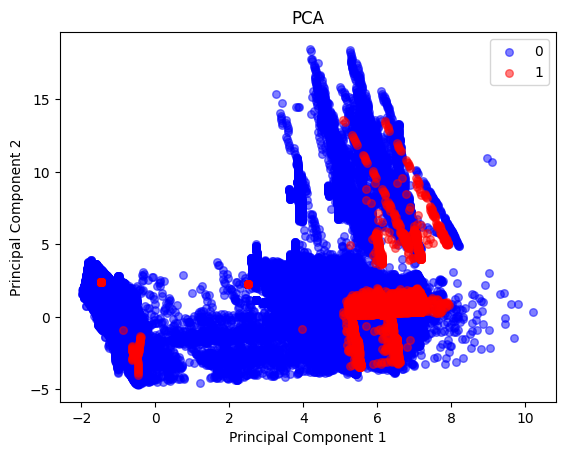

In [28]:
# Visualizng data in 2D using PCA

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA')

targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca_df['failure'] == target
    ax.scatter(final_pca_df.loc[indicesToKeep, 'principal component 1']
               , final_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , alpha = 0.5
               , s = 30)
ax.legend(targets)
plt.show()

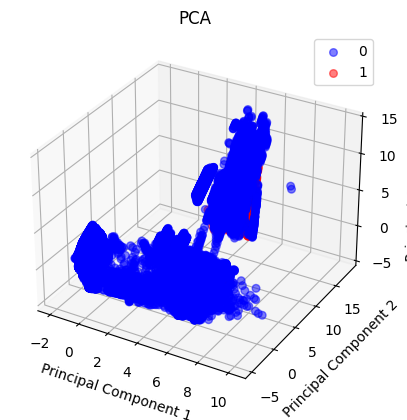

In [29]:
# Visualizng data in 3D using PCA

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA')

targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca_df['failure'] == target
    ax.scatter(final_pca_df.loc[indicesToKeep, 'principal component 1']
               , final_pca_df.loc[indicesToKeep, 'principal component 2']
               , final_pca_df.loc[indicesToKeep, 'principal component 3']
               , c = color
               , alpha = 0.5
               , s = 30)
ax.legend(targets)
plt.show()

## Modeling

### DBSCAN

In [27]:
# Finding nearest neighbors for setting the epsilon parameter of DBSCAN
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(final_pca_df[['principal component 1','principal component 2']])
distances, indices = nbrs.kneighbors(final_pca_df[['principal component 1','principal component 2']])

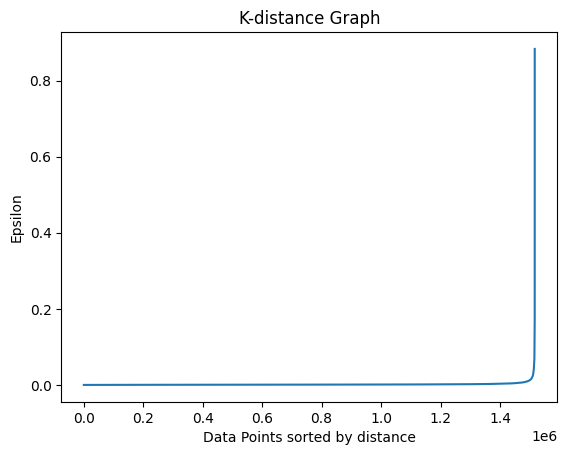

In [28]:
# Plotting K-distance Graph
sorted_distances = np.sort(distances, axis=0)[:,1]
plt.plot(sorted_distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [51]:
# Training the DBSCAN model
dbscan = DBSCAN(eps=0.03, min_samples=3)
dbscan.fit(final_pca_df[['principal component 1','principal component 2']])
dump(dbscan, 'dbscan.joblib')

['dbscan.joblib']

In [52]:
# Loading the saved model and printing out distinct clusters
dbscan = load('dbscan.joblib')
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

1062

In [53]:
# Calculating noise points or anomalies predicted by DBSCAN
noise_points = np.where(labels == -1)[0]
len(noise_points)

6677

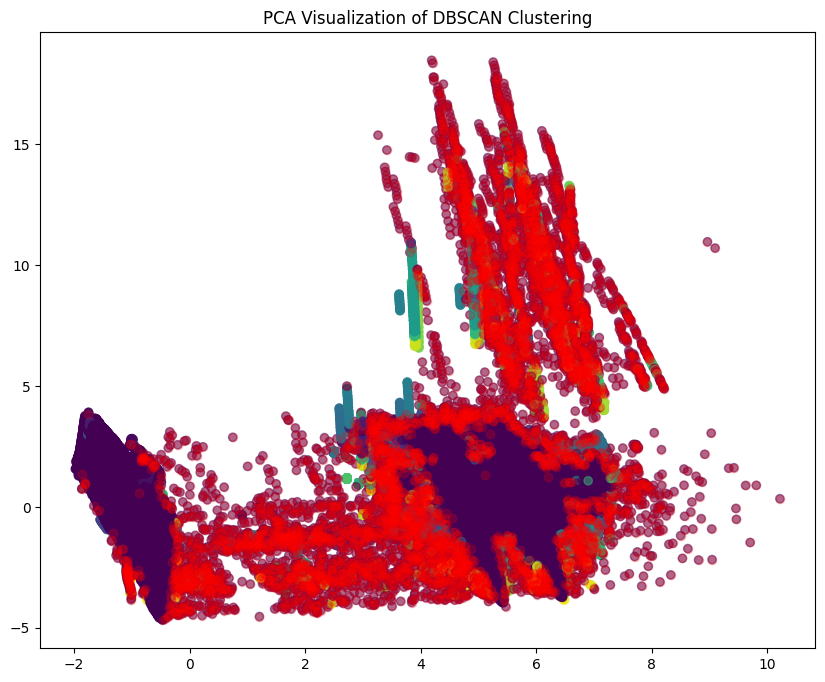

In [54]:
# Plotting DBSCAN results in 2D using PCA
plt.figure(figsize=(10, 8))
plt.scatter(final_pca_df.loc[:, 'principal component 1'], final_pca_df.loc[:, 'principal component 2'], c=labels, alpha=0.5)
plt.scatter(final_pca_df.loc[noise_points, 'principal component 1'], final_pca_df.loc[noise_points, 'principal component 2'], c="red", alpha=0.2)
plt.title('PCA Visualization of DBSCAN Clustering')
plt.show()

In [55]:
# Classifying noise points as failures to evaluate the model
actual_labels = df['failure']
predicted_labels = np.zeros_like(labels) # Initially setting all labels to 0
predicted_labels[noise_points] = 1       # Setting noise points as label 1
actual_labels.value_counts()             # Unique count of actual labels

failure
0    1486994
1      29954
Name: count, dtype: int64

In [56]:
# Unique count of predicted labels
np.unique(predicted_labels, return_counts=True)

(array([0, 1], dtype=int64), array([1510271,    6677], dtype=int64))

In [57]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1486994
           1       0.04      0.01      0.02     29954

    accuracy                           0.98   1516948
   macro avg       0.51      0.50      0.50   1516948
weighted avg       0.96      0.98      0.97   1516948



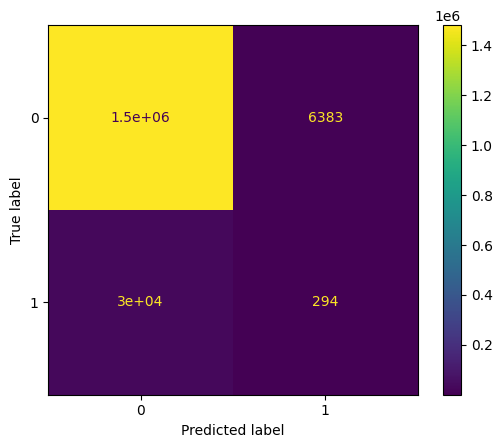

In [58]:
cm = confusion_matrix(actual_labels, predicted_labels)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

### OneClass SVM

In [10]:
# Initializing Features and Target
X = normalized_data
y = df['failure']

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train = X_train[y_train==0]  # For training model on one class (majority class)

In [37]:
# Training and saving the model
ocsvm = OneClassSVM(nu=0.01)
ocsvm.fit(X_train)
dump(ocsvm, 'ocsvm.joblib')

['ocsvm.joblib']

In [12]:
ocsvm = load('ocsvm.joblib')

In [53]:
# Predictions on combined dataset containing both classes (failure and non-failure)
pred = ocsvm.predict(X_test)
pred = [1 if i==-1 else 0 for i in pred]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    297324
           1       0.01      0.00      0.00      6066

    accuracy                           0.97    303390
   macro avg       0.49      0.50      0.49    303390
weighted avg       0.96      0.97      0.97    303390



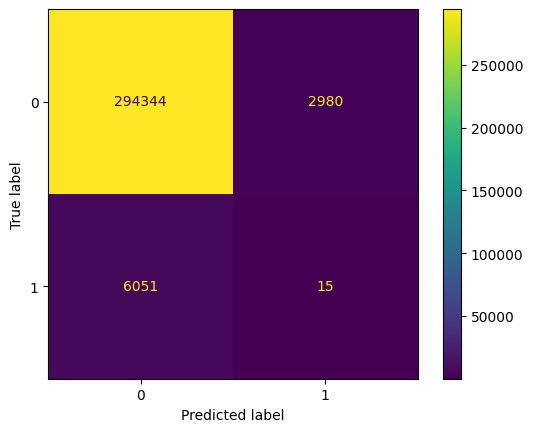

In [69]:
cm = confusion_matrix(y_test, pred)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

In [13]:
# Retrieving anomaly scores from X_test
anomaly_scores = ocsvm.decision_function(X_test)
anomaly_scores

array([575.37909456, 292.07544555, 275.41824615, ..., 245.35613013,
       220.68622349, 476.05695017])

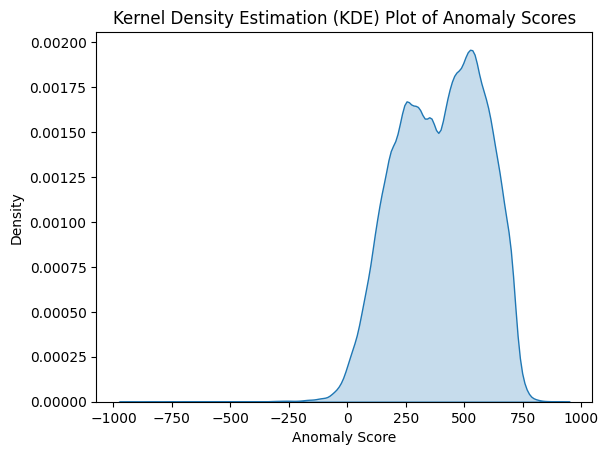

In [19]:
# Plotting KDE plot of anomaly scores
sns.kdeplot(anomaly_scores, fill=True)
plt.title('Kernel Density Estimation (KDE) Plot of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.show()

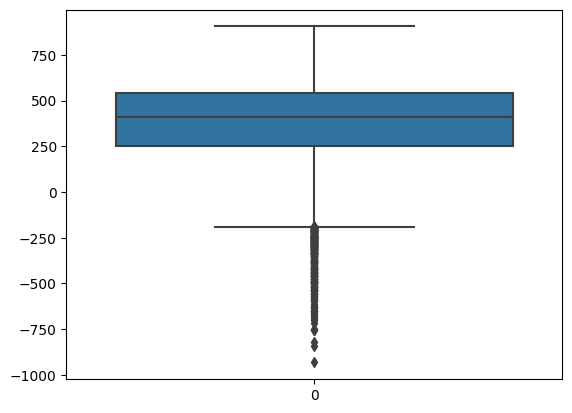

In [23]:
# Boxplot analysis of anomaly scores
sns.boxplot(anomaly_scores)
plt.show()

In [112]:
# Based on KDE plot and Boxplot, adjusting the threshold to analyze failures and normal points
lower_threshold = 50
upper_threshold = 800
new_pred = np.where((anomaly_scores > lower_threshold) & (anomaly_scores < upper_threshold), 1, 0)
print(classification_report(y_test, new_pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.05    297324
           1       0.02      1.00      0.04      6066

    accuracy                           0.05    303390
   macro avg       0.51      0.51      0.05    303390
weighted avg       0.98      0.05      0.05    303390



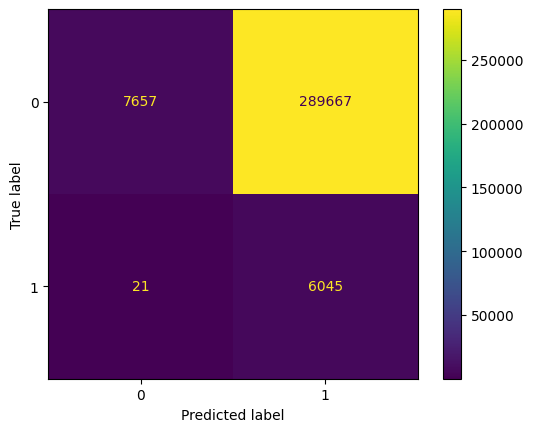

In [113]:
cm = confusion_matrix(y_test, new_pred)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

### Sparse Autoencoder

In [120]:
# Splitting the data into training and testing
X = normalized_data
y = df['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
# Model trained on normal data and used to predict combined data
normal_X_train = X_train[y_train==0]
failure_X_train = X_train[y_train==1]
normal_X_test = X_test[y_test==0]
failure_X_test = X_test[y_test==1]

In [355]:
# Building the SAE model

input_dim = normal_X_train.shape[1]
autoencoder = models.Sequential([
    # input layer
    layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )), 
    
    # encoder
    layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)),   # sparsity constraint
    layers.Dropout(0.2),                 # Dropout layers to reduce overfitting
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    
    # decoder
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='relu')
])

autoencoder.compile(optimizer="adam", loss="mae", metrics=["accuracy"])
autoencoder.summary();

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 19)                380       
                                                                 
 dense_97 (Dense)            (None, 16)                320       
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_98 (Dense)            (None, 8)                 136       
                                                                 
 dense_99 (Dense)            (None, 4)                 36        
                                                                 
 dense_100 (Dense)           (None, 2)                 10        
                                                                 
 dense_101 (Dense)           (None, 4)               

In [356]:
# saving the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder.h5",
                                                mode='min', 
                                                monitor='val_loss',
                                                save_best_only=True)
# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [357]:
# Training the model

BATCH_SIZE = 512
EPOCHS = 30
history = autoencoder.fit(normal_X_train, normal_X_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(normal_X_test, normal_X_test),
                    callbacks=[checkpoint, early_stop]).history

Epoch 1/30
2324/2324 [==============================] - 6s 2ms/step - loss: 0.2108 - accuracy: 0.1077 - val_loss: 0.1995 - val_accuracy: 0.0000e+00
Epoch 2/30
  52/2324 [..............................] - ETA: 4s - loss: 0.1977 - accuracy: 0.2405  

C:\Coding\Projects\ARP\arp-venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2324/2324 [==============================] - 5s 2ms/step - loss: 0.1894 - accuracy: 0.1298 - val_loss: 0.1797 - val_accuracy: 0.0000e+00
Epoch 3/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1817 - accuracy: 0.1241 - val_loss: 0.1808 - val_accuracy: 0.0000e+00
Epoch 4/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1816 - accuracy: 0.1288 - val_loss: 0.1804 - val_accuracy: 0.8540
Epoch 5/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1816 - accuracy: 0.1354 - val_loss: 0.1803 - val_accuracy: 0.8540
Epoch 6/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1816 - accuracy: 0.1333 - val_loss: 0.1803 - val_accuracy: 0.0000e+00
Epoch 7/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1816 - accuracy: 0.1304 - val_loss: 0.1802 - val_accuracy: 0.0000e+00
Epoch 8/30
2324/2324 [==============================] - 5s 2ms/step - loss: 0.1816 - accuracy: 0.1323 - val_loss: 0.1803 - val_accu

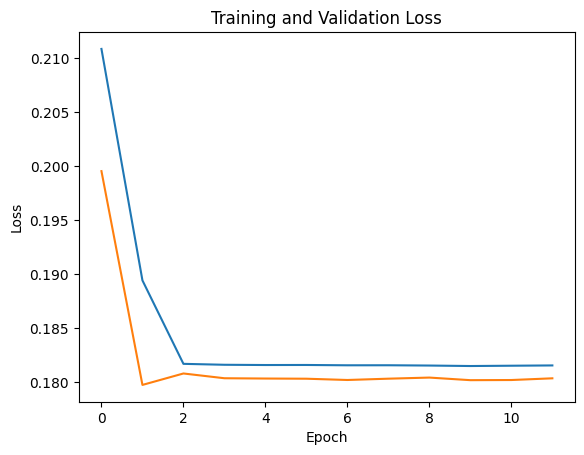

In [365]:
# Plotting training and validation loss

plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [60]:
autoencoder = load_model('autoencoder.h5')

In [63]:
# Retrieving the reconstructed values of X_test
reconstructions = autoencoder.predict(X_test)
reconstructions

9481/9481 [==============================] - 23s 2ms/step


array([[0.        , 0.8520978 , 0.        , ..., 0.5093232 , 0.6568029 ,
        0.5916111 ],
       [0.        , 0.85166955, 0.        , ..., 0.463827  , 0.20479798,
        0.1464153 ],
       [0.        , 0.85166955, 0.        , ..., 0.463827  , 0.20479798,
        0.1464153 ],
       ...,
       [0.        , 0.85166955, 0.        , ..., 0.463827  , 0.20479798,
        0.1464153 ],
       [0.        , 0.85166955, 0.        , ..., 0.463827  , 0.20479798,
        0.1464153 ],
       [0.        , 0.85193247, 0.        , ..., 0.49174887, 0.48220202,
        0.41964042]], dtype=float32)

In [64]:
reconstructions.shape

(303390, 19)

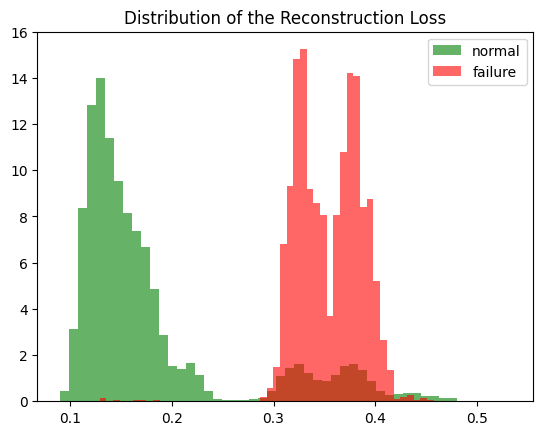

In [121]:
# Calculating the mean absolute error and plotting the reconstruction loss for normal and failure data

mae = np.mean(np.abs(X_test - reconstructions), axis=1)
non_failure = mae[y_test==0]   # Using indexing to separate normal and failure data
failure = mae[y_test==1]
plt.hist(non_failure, bins=50, density=True, label="normal", alpha=.6, color="green")
plt.hist(failure, bins=50, density=True, label="failure", alpha=.6, color="red")
plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [122]:
# Using the above plot to set a threshold and classify failures
threshold = 0.28
y_pred = [1 if i > threshold else 0 for i in mae]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    297324
           1       0.12      1.00      0.21      6066

    accuracy                           0.85    303390
   macro avg       0.56      0.92      0.57    303390
weighted avg       0.98      0.85      0.91    303390



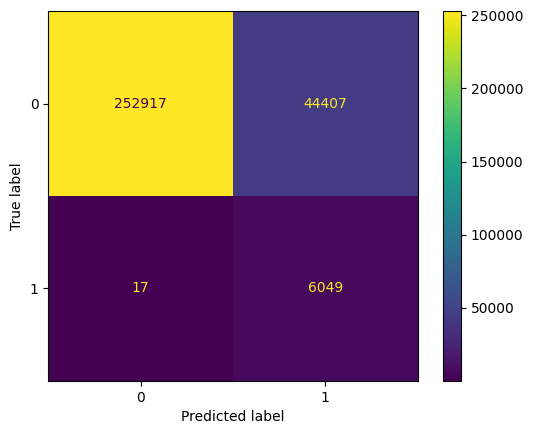

In [123]:
cm = confusion_matrix(y_test, y_pred)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

### LSTM

In [8]:
X = normalized_data
y = df['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [9]:
# Function to create time steps for input sequences

def get_sequences(X, y, look_back=1):
    Xval, yval = [], []
    for i in range(len(X)-look_back):               
        Xval.append(X.iloc[i:(i+look_back)].values)
        yval.append(y.iloc[i+look_back])
    return np.array(Xval), np.array(yval)

look_back = 10  # number of previous time steps to consider
X_train, y_train = get_sequences(X_train, y_train, look_back)
X_test, y_test = get_sequences(X_test, y_test, look_back)

In [113]:
# Building the LSTM model

input_dim = (X_train.shape[1], X_train.shape[2])
lstm = models.Sequential([

    layers.LSTM(19, activation='relu',input_shape=input_dim, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(8, activation='relu', return_sequences=False),
    
    layers.RepeatVector(X_train.shape[1]),   # Adds the sequence length to the input for the decoder

    layers.LSTM(8, activation='relu', return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(19, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(X_train.shape[2]))   # Applies the LSTM layer at each time step in the input
])

lstm.compile(optimizer="adam", loss="mae", metrics=["accuracy"])
lstm.summary();

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 10, 19)            2964      
                                                                 
 dropout_16 (Dropout)        (None, 10, 19)            0         
                                                                 
 lstm_33 (LSTM)              (None, 8)                 896       
                                                                 
 repeat_vector_8 (RepeatVec  (None, 10, 8)             0         
 tor)                                                            
                                                                 
 lstm_34 (LSTM)              (None, 10, 8)             544       
                                                                 
 dropout_17 (Dropout)        (None, 10, 8)             0         
                                                      

In [114]:
# saving the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="lstm.h5",
                                                mode='min', 
                                                monitor='val_loss',
                                                save_best_only=True)
# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [115]:
# Training the LSTM model

BATCH_SIZE = 512
EPOCHS = 30
history = lstm.fit(X_train, X_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpoint, early_stop]).history

Epoch 1/30
2134/2134 [==============================] - 38s 16ms/step - loss: 0.1098 - accuracy: 0.1350 - val_loss: 0.0797 - val_accuracy: 0.1401
Epoch 2/30
   5/2134 [..............................] - ETA: 30s - loss: 0.0659 - accuracy: 0.2284

C:\Coding\Projects\ARP\arp-venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2134/2134 [==============================] - 32s 15ms/step - loss: 0.0594 - accuracy: 0.2048 - val_loss: 0.0743 - val_accuracy: 0.1311
Epoch 3/30
2134/2134 [==============================] - 34s 16ms/step - loss: 0.0517 - accuracy: 0.2165 - val_loss: 0.0650 - val_accuracy: 0.4894
Epoch 4/30
2134/2134 [==============================] - 35s 16ms/step - loss: 0.0468 - accuracy: 0.2234 - val_loss: 0.0664 - val_accuracy: 0.2561
Epoch 5/30
2134/2134 [==============================] - 36s 17ms/step - loss: 0.0454 - accuracy: 0.2270 - val_loss: 0.0678 - val_accuracy: 0.3248
Epoch 6/30
2134/2134 [==============================] - 35s 16ms/step - loss: 0.0444 - accuracy: 0.2220 - val_loss: 0.0684 - val_accuracy: 0.2155
Epoch 7/30
2134/2134 [==============================] - 36s 17ms/step - loss: 0.0436 - accuracy: 0.2147 - val_loss: 0.0700 - val_accuracy: 0.0632
Epoch 8/30
2134/2134 [==============================] - 35s 16ms/step - loss: 0.0424 - accuracy: 0.2052 - val_loss: 0.0705 - val_accura

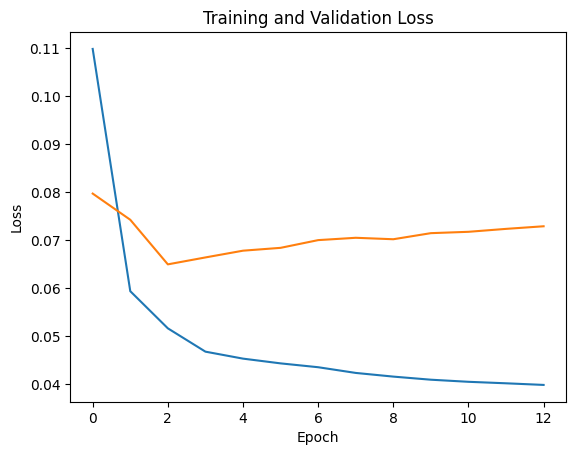

In [116]:
# Plotting training and validation loss

plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Loading model and predicting on X-test
lstm = load_model('lstm.h5')
reconstructions = lstm.predict(X_test)


9481/9481 [==============================] - 70s 7ms/step


In [20]:
# Calculating the average of each reconstruction, since it is in sequences to match the original dimension of data
reconstructions_avg = np.mean(reconstructions, axis=1)
X = normalized_data
y = df['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
# Dropping the last unused X_test to match reconstructions shape
X_test_truncated = X_test[:-10]
y_test_truncated = y_test[:-10]

In [21]:
reconstructions_avg.shape

(303380, 19)

In [22]:
X_test_truncated.shape

(303380, 19)

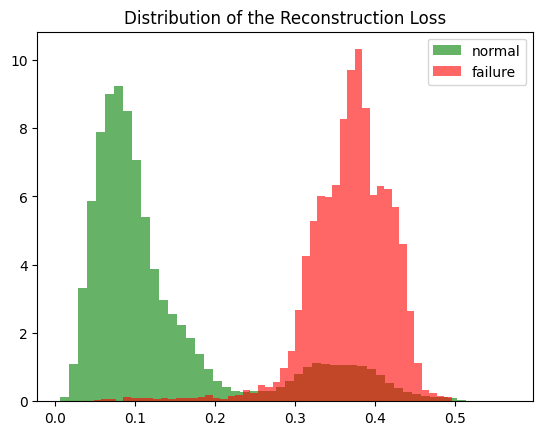

In [23]:
# Calculating mae and plotting reconstruction loss
mae = np.mean(np.abs(X_test_truncated - reconstructions_avg), axis=1)
non_failure = mae[y_test_truncated==0]
failure = mae[y_test_truncated==1]
plt.hist(non_failure, bins=50, density=True, label="normal", alpha=.6, color="green")
plt.hist(failure, bins=50, density=True, label="failure", alpha=.6, color="red")
plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [30]:
# Choosing threshold based on above plot for classification
threshold = 0.27
y_pred = [1 if i > threshold else 0 for i in mae]
print(classification_report(y_test_truncated, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    297314
           1       0.12      0.97      0.21      6066

    accuracy                           0.85    303380
   macro avg       0.56      0.91      0.57    303380
weighted avg       0.98      0.85      0.91    303380



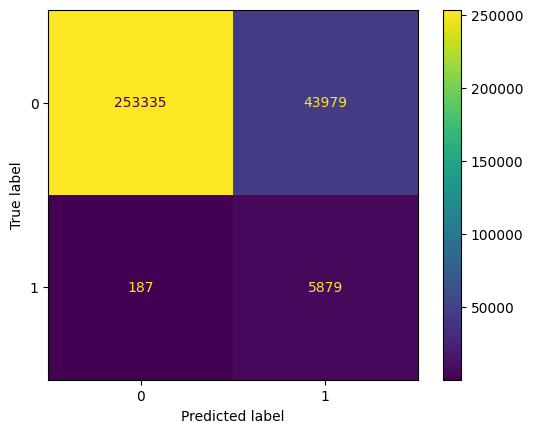

In [31]:
cm = confusion_matrix(y_test_truncated, y_pred)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

### Random Forest

In [79]:
X = df.drop(['timestamp','failure'], axis=1)
y = df['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [9]:
# Training and saving random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
dump(rf, 'rf.joblib')

['rf.joblib']

In [80]:
# Predictions
rf = load('rf.joblib')
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    297324
           1       0.98      0.99      0.99      6066

    accuracy                           1.00    303390
   macro avg       0.99      0.99      0.99    303390
weighted avg       1.00      1.00      1.00    303390



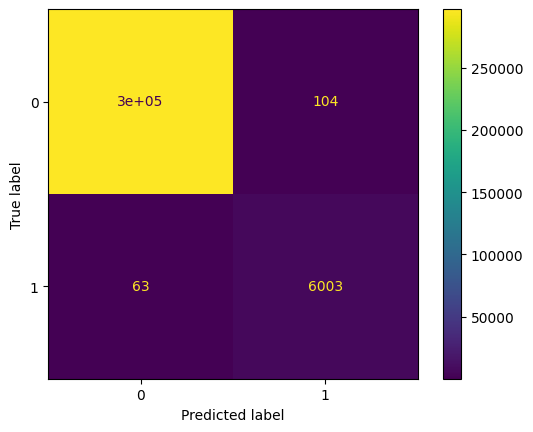

In [81]:
cm = confusion_matrix(y_test, y_pred)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()

In [17]:
# Cross-validation of the RF model

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy: {cv_scores.mean()}')
print(f'Standard deviation: {cv_scores.std()}')

Cross-validation scores: [0.99944296 0.99937045 0.99945944 0.99944296 0.99946274]
Mean accuracy: 0.9994357090910679
Standard deviation: 3.363911240135363e-05


In [12]:
# Retrieving the feature importances and storing into pandas dataframe

importances = rf.feature_importances_
features = X.columns

feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

feature_importances

,Feature,Importance
3,DV_pressure,0.345602
5,Oil_temperature,0.238773
1,TP3,0.104383
4,Reservoirs,0.098950
2,H1,0.066119
0,TP2,0.063614
6,Motor_current,0.049730
8,DV_eletric,0.010150
7,COMP,0.009738
10,MPG,0.006862


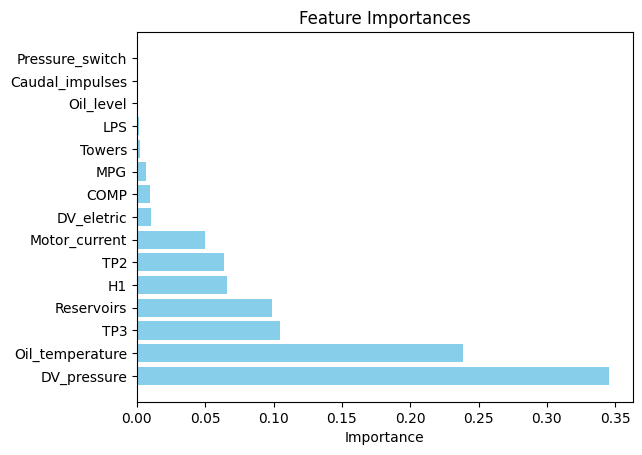

In [13]:
# Plotting horizontal bar chart of feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

### Integrated Model

In [101]:
# Building the integrated model by passing false alarms of SAE results to the Random Forest model for filtering

false_alarm_data = non_failure[non_failure > threshold]  # Retrieving false positive data points from sparse encoder output
false_alarm_data = df.iloc[false_alarm_data.index]       # Matching the index values of the false positives with the df to create new test data
false_alarm_data = false_alarm_data.drop(['timestamp','failure'], axis=1)
false_alarm_data.shape

(44407, 15)

In [142]:
# Retrieving the target labels of the false positives from the y_test from earlier data split
false_alarm_y_test = y_test[false_alarm_data.index]
false_alarm_y_test.shape

(44407,)

In [145]:
false_alarm_y_pred = rf.predict(false_alarm_data)   # Predicting new false alarm data
false_alarm_y_pred[false_alarm_y_pred == 1] = threshold + 0.1   # setting failure class values to threshold + 0.1
false_alarm_y_pred[false_alarm_y_pred == 0] = threshold - 0.1   # setting normal class values to threshold - 0.1
mae_updated = mae.copy()
mae_updated[false_alarm_y_test.index] = false_alarm_y_pred      # updating the mean absolute error series with the new values with the help of indices
y_pred_updated = [1 if i > threshold else 0 for i in mae_updated]  # re-assigning the y_pred based on updated mae
print(classification_report(y_test, y_pred_updated))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    297324
           1       1.00      1.00      1.00      6066

    accuracy                           1.00    303390
   macro avg       1.00      1.00      1.00    303390
weighted avg       1.00      1.00      1.00    303390



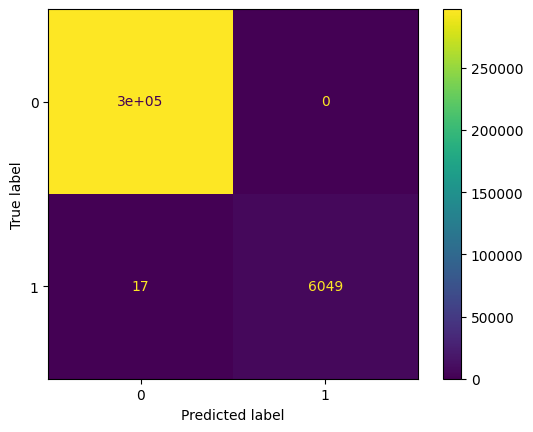

In [146]:
cm = confusion_matrix(y_test, y_pred_updated)
cmplot = ConfusionMatrixDisplay(cm)
cmplot.plot()
plt.show()